In [9]:
import pandas as pd
import datetime
import pyomo.environ as pyomo
import matplotlib.pyplot as plt
import numpy as np

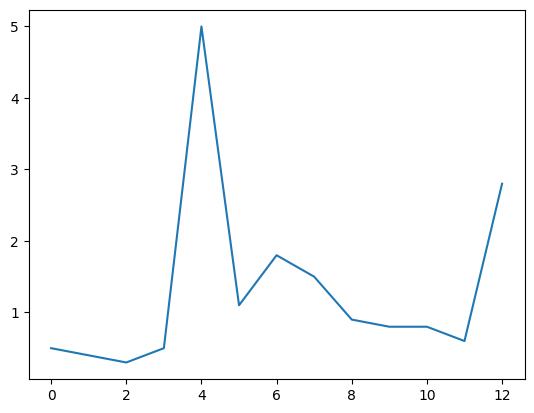

In [10]:
price_schedule = {
    0 : 0.5,
    1 : 0.4,
    2 : 0.3,
    3 : 0.5,
    4 : 5,
    5 : 1.1,
    6 : 1.8,
    7 : 1.5,
    8 : 0.9,
    9 : 0.8,
    10 : 0.8,
    11 : 0.6,
    12: 2.8
}

Temp_out ={
    0 : 20,
    1 : 20,
    2 : 20,
    3 : 20,
    4 : 20,
    5 : 20,
    6 : 20,
    7 : 20,
    8 : 20,
    9 : 20,
    10 : 20,
    11 : 20,
    12: 20
}


T_room0 = 3.5
T_roomax = 5
T_roomin = 1

A_ins = 3.21
mc_thmass = 30

cop_hvac = 3
P_hvac = 30

dt = 1

epsilon = np.exp((-dt * A_ins)/mc_thmass)



load_profile = 200

plt.plot(range(13),[price_schedule[i] for i in range (13)])

In [11]:
model = pyomo.ConcreteModel()

# -------------------- Parameters and constant information
# Nº time steps
model.nt = pyomo.Param(initialize = len(price_schedule), domain = pyomo.Integers)
# Set of time steps
model.T = pyomo.Set(initialize = range(model.nt()))
# Price of electricity at each time step
model.price = pyomo.Param(model.T, initialize = price_schedule)
# Temp outside
model.T_out = pyomo.Param(model.T, initialize = Temp_out)

model.T_0 = pyomo.Param( initialize = T_room0)
model.T_max = pyomo.Param( initialize = T_roomax)
model.T_min = pyomo.Param( initialize = T_roomin)

model.A = pyomo.Param( initialize = A_ins)
model.mc_tmass = pyomo.Param( initialize = mc_thmass)

model.cop = pyomo.Param( initialize = cop_hvac)
model.P_r = pyomo.Param( initialize = P_hvac)

model.deltat = pyomo.Param( initialize = dt)

model.e = pyomo.Param(initialize = epsilon)

# -------------------- Variables
# Load activity flag
model.w = pyomo.Var(model.T, domain = pyomo.Binary)
# Temperature inside
model.t_i = pyomo.Var(model.T)

#model.heat = pyomo.Var(model.T)
#model.wh = pyomo.Var(model.T, domain = pyomo.Binary)

#model.P = pyomo.Param(model.T)

# -------------------- Objective Function
def objective_func(model):
    # sum the price of electricity purchased for all timesteps
    return sum([model.w[t] * model.price[t] * model.P_r for t in model.T])
    #return sum([model.w[t] * model.price[t] * model.P[t] + model.wh[t] * model.price[t] * model.P[t] for t in model.T])
model.objective = pyomo.Objective(rule = objective_func, sense = pyomo.minimize)


# --------------------- Constraints

# Temperature balance

def temp_history(model, t):
    if t==0:
        # inicial temperature
        return model.t_i[t] == model.T_0
    else:
        #return model.t_i[t] == (model.t_i[t-1] - model.T_out[t] - model.heat[t]) * model.e + model.heat[t-1] + model.T_out[t-1] - (model.w[t-1]*model.cop*model.P[t]*((1-model.e)/model.A) + model.w[t]*model.cop*model.P[t]*((1-model.e)/model.A))
        return model.t_i[t] == (model.t_i[t-1] - model.T_out[t]) * model.e + model.T_out[t-1] - (model.w[t-1]*model.cop*model.P_r*((1-model.e)/model.A) + model.w[t]*model.cop*model.P_r*((1-model.e)/model.A))
model.temp_history = pyomo.Constraint(model.T, rule = temp_history)

def max_temp (model,t):
    return model.t_i[t]  <= model.T_max
model.max_temp = pyomo.Constraint(model.T, rule = max_temp)

def min_temp (model,t):
    return model.t_i[t] >= model.T_min
model.min_temp = pyomo.Constraint(model.T, rule = min_temp)

#def pmax(model,t):
#    if t==0:
#        return model.P_r == 0
#    else:
#        return model.P_r <= model.P_r
#model.pmax = pyomo.Constraint(model.T, rule = pmax)

In [12]:
# set up solver
solver = pyomo.SolverFactory('cplex', executable = "C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe")
# run the simulation
results = solver.solve(model, keepfiles = True, logfile = "solve.log")

Solver script file=C:\Users\JPSM1\AppData\Local\Temp\tmpqeanlk05.cplex.script
Solver log file: 'solve.log'
Solver solution file: 'C:\Users\JPSM1\AppData\Local\Temp\tmp8c_vzlo9.cplex.sol'
Solver problem files: ('C:\\Users\\JPSM1\\AppData\\Local\\Temp\\tmp2u21jcs6.pyomo.lp',)


In [13]:
print(model.display())
print(f"time\tprice\tflagw")
for t in model.T:
    print(f'{t}\t{model.price[t]:.2f}\t{model.w[t]}')

Model unknown

  Variables:
    w : Size=13, Index=T
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   1.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :  -0.0 :     1 : False : False : Binary
          5 :     0 :   1.0 :     1 : False : False : Binary
          6 :     0 :  -0.0 :     1 : False : False : Binary
          7 :     0 :  -0.0 :     1 : False : False : Binary
          8 :     0 :   1.0 :     1 : False : False : Binary
          9 :     0 :  -0.0 :     1 : False : False : Binary
         10 :     0 :  -0.0 :     1 : False : False : Binary
         11 :     0 :   1.0 :     1 : False : False : Binary
         12 :     0 :  -0.0 :     1 : False : False : Binary
    t_i : Size=13, Index=T
        Key : Lower : Value              : Upper : Fixed : Stale :

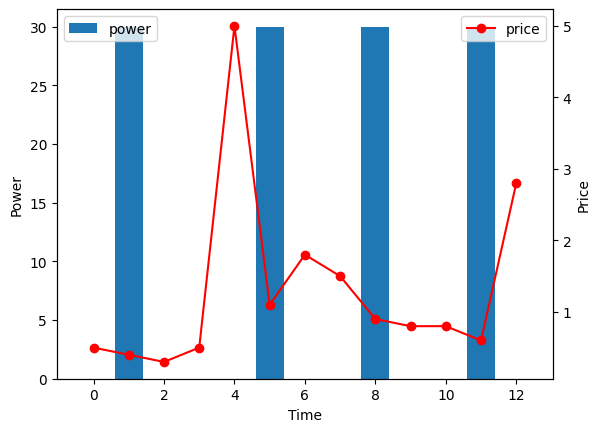

In [14]:
# plot results
plt.bar(range(model.nt()), [model.w[t]()*model.P_r for t in model.T], label = "power") 
plt.ylabel("Power")
plt.xlabel("Time")
plt.legend(loc=2)
ax = plt.gca().twinx()
ax.plot(range(model.nt()), [model.price[t] for t in model.T], label = "price", color='red', marker='o')
ax.set_ylabel("Price")
plt.legend()

plt.show()


for index 0 X[0] is: 3.5
for index 1 X[1] is: 2.3292518066031036
for index 2 X[2] is: 1.2773044982289736
for index 3 X[3] is: 3.1771774240786224
for index 4 X[4] is: 4.88426202337374
for index 5 X[5] is: 3.5730467727499153
for index 6 X[6] is: 2.3948862072479917
for index 7 X[7] is: 4.181353281296592
for index 8 X[8] is: 2.941465222224277
for index 9 X[9] is: 1.827393969513682
for index 10 X[10] is: 3.671446936469597
for index 11 X[11] is: 2.483301280576575
for index 12 X[12] is: 1.4157219055047894
0     3.500000
1     2.329252
2     1.277304
3     3.177177
4     4.884262
5     3.573047
6     2.394886
7     4.181353
8     2.941465
9     1.827394
10    3.671447
11    2.483301
12    1.415722
Name: t_i, dtype: float64


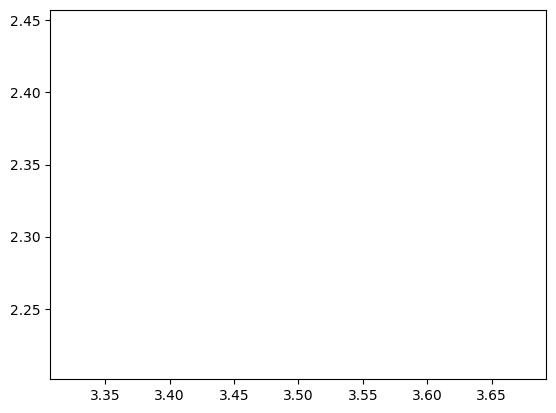

In [15]:
for s in model.T:
    print(f'for index {s} X[{s}] is: {model.t_i[s].value}')

x_vals = pd.Series(model.t_i.extract_values(), name=model.t_i.name)
print(x_vals)

x = x_vals[0]
y = x_vals[1]
plt.plot(x,y)
plt.show()

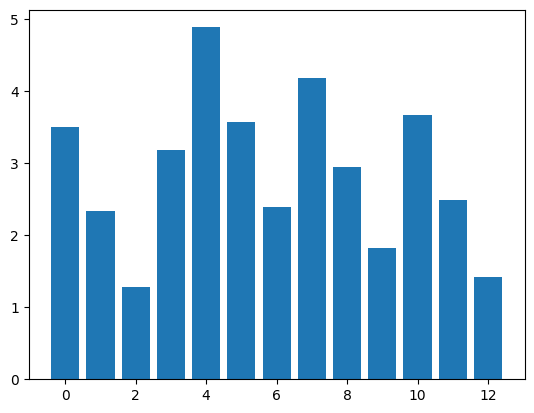

In [16]:
x = range(13)
y = x_vals
plt.bar(x,y)
plt.show()